# Perform forward kinematics with a trajectory

In this notebook, we are going to generate a short video for a random robot movement you can watch in your browser.

First of all, we need some modules. You can create some simple modules built from geometric primitives yourself - there is a distinct tutorial to that purpose. If you don't want to, we can use the set of simple modules provided with the timor source code:

In [31]:
from pathlib import Path

# provide your own filepaths if you already did the module generation tutorial:
your_modules_json = Path('')
your_assets_directory = Path('')

if your_modules_json == Path(''):
    from timor.utilities.file_locations import get_module_db_files
    modules_file = get_module_db_files('geometric_primitive_modules')

In [32]:
import numpy as np
import timor
from timor.Module import *
from timor.utilities.visualization import animation

#create the DB object
db = ModulesDB.from_json_file(modules_file)

#print out available modules in DB
print(db.by_name)
print(db.by_id)
# print(db.all_joints)
# print(db.all_connectors)


{'L shaped link 0.1-0.08-30': <timor.Module.AtomicModule object at 0x73228eb77ac0>, 'Demo EEF': <timor.Module.AtomicModule object at 0x73228eb768f0>, 'I shaped link 0.08-0.08-45': <timor.Module.AtomicModule object at 0x73228eb76920>, 'L shaped link 0.1-0.08-45': <timor.Module.AtomicModule object at 0x73228ebdc310>, 'L shaped link 0.1-0.08-15': <timor.Module.AtomicModule object at 0x73228eb772b0>, 'Base': <timor.Module.AtomicModule object at 0x73228eb76f20>, 'Revolute Joint': <timor.Module.AtomicModule object at 0x73228eb75300>, 'I shaped link 0.08-0.08-15': <timor.Module.AtomicModule object at 0x73228eb75690>, 'Prismatic Joint': <timor.Module.AtomicModule object at 0x73228eb519c0>, 'I shaped link 0.08-0.08-30': <timor.Module.AtomicModule object at 0x73228eb740d0>}
{'l_30': <timor.Module.AtomicModule object at 0x73228eb77ac0>, 'eef': <timor.Module.AtomicModule object at 0x73228eb768f0>, 'i_45': <timor.Module.AtomicModule object at 0x73228eb76920>, 'l_45': <timor.Module.AtomicModule obje

In [33]:
#contains IDs we care about. The order is arbitrary, but if we want to make a robot out of this (i.e. kinematic tree) we should put in order.
modules = ('base', 'J2', 'i_45', 'J2', 'J2', 'eef')
A = ModuleAssembly.from_serial_modules(db, modules)
robot = A.to_pin_robot() #convert to pinocchio robot

viz = robot.visualize()
viz.viewer.jupyter_cell(height=400) # generate a jupyter cell to visualize the robot

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7054/static/


In [34]:
#arbitrary new joint state
q2 = np.array([np.pi, -np.pi/2, np.pi/2])


"""Forwards Kinematics (FK) and Forwards Dynamics (FD) methods belong to PinRobot object"""
  # FK https://timor-python.readthedocs.io/en/latest/autoapi/timor/Robot/index.html#timor.Robot.PinRobot.fk
  # FD https://timor-python.readthedocs.io/en/latest/autoapi/timor/Robot/index.html#timor.Robot.PinRobot.fd

# FK calculates the relative rigid body transform from the reference config at a given joint angle position. 
# You can tell it to update the collision hitbox and visual mesh if wanted. I don't think this robot can collide with itself.
print(f"Robot end effector coordinate transform at joint state {q2}", robot.fk(configuration = q2, collision = True, visual = True)) #default kind is tcp - tool center point
print(f"Robot joint coordinate transfom at joint state {q2}", robot.fk(configuration = q2, kind = 'joints', collision = True, visual = True))
print(f"Robot full frames coordinate transfom at joint state {q2}", robot.fk(configuration = q2, kind = 'full', collision = True, visual = True))


#visual just updates the state of the visual geometries, we have to actually visualize to see it
vis = robot.visualize()

#Current robot velocities
print(f"Current robot joint positions (configuration): {robot.configuration}")
print(f"Current robot joint velocities: {robot.velocities}")

# FD calculates joint accelerations (ddq) given joint config (q) and joint velocity (dq) 
print(robot.fd(tau = [1, 0, 0], motor_inertia = False, friction = True))
  

Robot end effector coordinate transform at joint state [ 3.14159265 -1.57079633  1.57079633] [[-0.    1.   -0.    0.5 ]
 [-0.   -0.   -1.   -0.19]
 [-1.   -0.    0.    0.8 ]
 [ 0.    0.    0.    1.  ]]
Robot joint coordinate transfom at joint state [ 3.14159265 -1.57079633  1.57079633] ([[ 1.    0.    0.    0.2 ]
 [-0.    1.    0.   -0.  ]
 [ 0.   -0.    1.    0.05]
 [ 0.    0.    0.    1.  ]], [[-0.   0.   1.   0.2]
 [-1.  -0.  -0.   0. ]
 [ 0.  -1.   0.   0.8]
 [ 0.   0.   0.   1. ]], [[-0.   1.  -0.   0.5]
 [-0.  -0.  -1.   0. ]
 [-1.  -0.   0.   0.8]
 [ 0.   0.   0.   1. ]])
Robot full frames coordinate transfom at joint state [ 3.14159265 -1.57079633  1.57079633] ([[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]], [[ 1.  0.  0.  0.]
 [ 0. -1. -0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0.  1.]], [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]], [[-0.   -0.    1.    0.05]
 [ 0.   -1.    0.    0.  ]
 [ 1.    0.    0.    0.05]
 [ 0.    0.    0.    1.  ]], [[-0.    0

## Workspace using Forward Kinematics
Using the joint space, we compute a list of reachable poses for a given robot. A pose is reachable if:
1. there are no self collisions 
2. there are no collisions with any obstacles in the task (or environment)
3. you can reach the target pose from the previous pose (for now, we assume the prev pose to be the initial configuration)

In [35]:
def specific_pose_valid(robot, theta, task = None) -> bool:
	"""
	Given a robot at a specific pose, evaluate whether it is a valid pose (contains no collision).
	TODO: reach target pose from the previous pose

	Args:
		robot (timor.Robot.PinRobot): robot
		theta (list[float]): joint angles configuration
		task (timor.task.Task, optional): environment with obstacles. Defaults to None.

	Returns:
		bool: (for now) True if robot has no collision, False otherwise 
	"""		
	# perform FK on the theta list
	g = robot.fk(theta, visual = True, collision = True)

	self_collisions = robot.has_self_collision()
	collisions = False if task is None else robot.has_collisions(task, safety_margin=0) # TODO may need to alter safety margin

	return not (collisions or self_collisions)

In [36]:
import itertools

def find_all_valid_poses(robot, angle_interval, task = None) -> set[tuple[float, float, float]]:
    """
    Finds all the valid poses that are reachable by iterating through the robot's joint space.

    Args:
        robot (timor.Robot.PinRobot): our robot
        angle_interval (int): how many times do we split the range of angles from 0 to 2pi
        task (timor.task.Task, optional): task containing obstacles. Defaults to None.

    Returns:
        set[tuple[float, float, float]]: a list containing all joints combinations that result in a valid pose.
    """
    # Generate all possible combinations of joint angles
    num_joints = len(robot.joints)
    angles = np.linspace(0, 2 * np.pi, angle_interval)
    all_angles_combo = itertools.product(angles, repeat=num_joints)
    
    # To store all valid poses, multiple joint combos may result in the same end-effector position
    valid_poses = set()
    
    for theta in all_angles_combo:
        print("Testing theta comb: ", theta)
        
        if (specific_pose_valid(robot, theta)):
            # extract the end-effector position from g
            g = robot.fk(theta, visual = True, collision = True)
            end_effector_pose = tuple(g[:3, 3].flatten())  # Convert to tuple for hashing
            valid_poses.add(end_effector_pose)
            print("\t-->EE POSE: ", end_effector_pose)
        else:
            print("\tNOPE")
            
    return valid_poses

In [37]:
"""Example of manually defined trajectory with Forwards Kinematics (pt 1)"""

modules = ('base', 'i_30', 'J2', 'J2', 'J2', 'i_30', 'eef')
B = ModuleAssembly.from_serial_modules(db, modules)
long_robot = B.to_pin_robot() #convert to pinocchio robot

q_0 = [np.pi, np.pi, np.pi] #start in this config with no collisions

no_collision_eff = long_robot.fk(q_0, collision = True, visual = True)

#the collisions() method exists, but requires the definition of a task. we look at collision pairs as a quick shortcut.
print("Self collision in this state: ", long_robot.has_self_collision())
long_robot.visualize_self_collisions() #nothing is highlighted b/c no self collisions

print(q_0)
print("--Specific pose valid: ", specific_pose_valid(long_robot, q_0))

q_1 = [0.0,0.0,0.0] #this has collision
collision_eff = long_robot.fk(q_1, collision = True, visual = True)
print(collision_eff)

#the collisions() method exists, but requires the definition of a task. we look at collision pairs as a quick shortcut.
print("Self collision in this state: ", long_robot.has_self_collision())
long_robot.visualize_self_collisions() #nothing is highlighted b/c no self collisions

print(q_1)
print("==Specific pose valid: ", specific_pose_valid(long_robot, q_1))

Self collision in this state:  False
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7056/static/
[3.141592653589793, 3.141592653589793, 3.141592653589793]
--Specific pose valid:  True
[[ 1.    0.    0.    0.2 ]
 [-0.   -1.   -0.   -0.  ]
 [ 0.    0.   -1.   -0.14]
 [ 0.    0.    0.    1.  ]]
Self collision in this state:  True
collision pair detected: 1 , 11 - collision: Yes
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7057/static/
[0.0, 0.0, 0.0]
==Specific pose valid:  False


In [38]:
"""Testing a longer robot."""
modules = ('base', 'i_30', 'J2', 'J2', 'J2', 'i_30', 'eef')
B = ModuleAssembly.from_serial_modules(db, modules)
long_robot = B.to_pin_robot() #convert to pinocchio robot

viz = robot.visualize()
viz.viewer.jupyter_cell(height=400) # generate a jupyter cell to visualize the robot

valid_poses = find_all_valid_poses(long_robot, 3)
print(valid_poses)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7058/static/
Testing theta comb:  (0.0, 0.0, 0.0)
	NOPE
Testing theta comb:  (0.0, 0.0, 3.141592653589793)
	NOPE
Testing theta comb:  (0.0, 0.0, 6.283185307179586)
	NOPE
Testing theta comb:  (0.0, 3.141592653589793, 0.0)
	-->EE POSE:  (0.2, 2.7554552980815448e-17, 0.84)
Testing theta comb:  (0.0, 3.141592653589793, 3.141592653589793)
	-->EE POSE:  (0.2, -9.184850993605147e-18, 0.84)
Testing theta comb:  (0.0, 3.141592653589793, 6.283185307179586)
	-->EE POSE:  (0.2, 2.7554552980815448e-17, 0.84)
Testing theta comb:  (0.0, 6.283185307179586, 0.0)
	NOPE
Testing theta comb:  (0.0, 6.283185307179586, 3.141592653589793)
	NOPE
Testing theta comb:  (0.0, 6.283185307179586, 6.283185307179586)
	NOPE
Testing theta comb:  (3.141592653589793, 0.0, 0.0)
	-->EE POSE:  (0.8, -5.0822842164615156e-17, -0.1399999999999999)
Testing theta comb:  (3.141592653589793, 0.0, 3.141592653589793)
	-->EE POSE:  (0.8, -8.756224613903575e-17

In [39]:
def find_trajectory(robot, base_config, target_config, task = None, max_rrt_iters: int = 10000, rrt_step_size: float = 0.1, target_distance_thresh: float = 0.2):
	'''
		Checks if a target pose is reachable from a base pose through any valid trajectory. 
		Returns a valid trajectory if found. Does not guarantee anything close to optimality.
		
		This implementation uses Rapidly-exploring Random Trees (RRT).

		IMPORTANT - this function works entirely within the joint space. no calculation of actual end effector position is done. this matters for the target distance threshold!

		Parameters:
			- robot
			- target_config
			- base_config
			- task
			- max_rrt_iters
			- rrt_step_size
			- target_distance_thresh

		Returns:
			- the whole tree (for now) if a trajectory exists. None otherwise

		TODO:
			- make the tree an actual tree - this impl is a little scuffed
	'''

	#if the base or target poses are invalid, no trajectory is possible.	
	if not specific_pose_valid(robot, base_config, task) or not specific_pose_valid(robot, target_config, task):
		return None

	#each node in the tree contains a tuple of (joint_angles: List[float], parent: Integer) - parent is the parent index 
	tree = [base_config]
	idx_to_parent = dict()
	idx_to_parent[0] = -1

	#nx2 arr - of lower and upper angle limits for each joint
	joint_space_bounds = robot.joint_limits
	low_bounds, high_bounds = joint_space_bounds[0], joint_space_bounds[1]

	#RRT Algo
	for _ in range(max_rrt_iters):
		# Sample random configuration
		random_config = np.random.uniform(low_bounds, high_bounds)
		
		# Find nearest node in the tree
		nearest_config_idx, nearest_config = min(enumerate(tree), key=lambda x: np.linalg.norm(x[1] - random_config))
		
		# Extend towards random config
		new_config = nearest_config + rrt_step_size * (random_config - nearest_config) / np.linalg.norm(random_config - nearest_config)
		#if the new config that we step into is valid, add it to the tree. we can 
		if specific_pose_valid(robot, new_config, task):
			# print(new_config, len(tree))
			#append a new config and its parent's idx in the tree
			idx_to_parent[len(tree)] = nearest_config_idx
			tree.append(new_config)
			
			# Check if we've reached the target. if so, return
			if np.linalg.norm(new_config - target_config) < target_distance_thresh:
				full_path = [target_config]

				next_node, parent_idx = new_config, nearest_config_idx

				while parent_idx != -1:
					full_path.insert(0, next_node)
					next_node, parent_idx = tree[parent_idx], idx_to_parent[parent_idx]

				return full_path
	
	#no trajectories are valid. return None
	return None

In [40]:
traj = find_trajectory(robot, [0, 0, 0], [np.pi/2, np.pi, np.pi/2], target_distance_thresh = 1)
    
if traj:
    traj = np.array(traj)
    print(f"Found trajectory of length {traj.shape[0]}: \n{traj}")
    animation(robot, traj, .1)

Found trajectory of length 56: 
[[-3.58637868e-04  9.92809784e-02 -1.19648947e-02]
 [-5.11315840e-02  1.40958491e-01  6.34346600e-02]
 [-2.68673087e-02  2.35585326e-01  8.48123865e-02]
 [-1.00437288e-02  3.29552568e-01  5.50277505e-02]
 [ 6.65234894e-02  3.91859721e-01  7.10052275e-02]
 [ 1.04055272e-01  4.63668678e-01  1.29612727e-01]
 [ 8.72477973e-02  5.27221715e-01  2.04968684e-01]
 [ 1.50564318e-01  5.78418360e-01  2.63019711e-01]
 [ 2.15532937e-01  6.37834237e-01  3.10441564e-01]
 [ 2.22191785e-01  7.15855905e-01  3.72637056e-01]
 [ 1.61506048e-01  7.42323169e-01  4.47581871e-01]
 [ 2.17287290e-01  7.90650223e-01  5.15057414e-01]
 [ 1.98706879e-01  8.24805761e-01  6.07188666e-01]
 [ 1.80117098e-01  9.22864617e-01  6.00953220e-01]
 [ 2.62401467e-01  9.78920104e-01  5.91622355e-01]
 [ 2.38255297e-01  1.02823347e+00  6.75199592e-01]
 [ 2.55289755e-01  1.06236235e+00  7.67639014e-01]
 [ 2.49995402e-01  1.15773243e+00  7.97245050e-01]
 [ 2.65423946e-01  1.20641314e+00  8.83222653e-01]

In [41]:
from timor.utilities.transformation import Transformation
from timor.utilities.tolerated_pose import ToleratedPose

no_collision_t = Transformation(no_collision_eff)
no_collision_pose = ToleratedPose(no_collision_t)

In [42]:
def inverse_kinematics(robot, eff_pose):
    transformation = Transformation(eff_pose)
    tolerated_pose = ToleratedPose(transformation)
    
    return robot.ik(tolerated_pose)

In [43]:
#print(long_robot.ik(no_collision_pose))
print(inverse_kinematics(long_robot, no_collision_eff))
print(inverse_kinematics(long_robot, collision_eff))
#print(long_robot.ik(collision_eff))

(array([3.14159265, 3.14159265, 3.14159265]), True)


2024-10-31 12:35:34,52 Timor INFO IK failed to converge.


(array([-0.08068967,  0.00712176, -0.01558387]), False)


In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

def check_reachable_cubes(robot, space_dimensions, segment_len, error):
    # Extract the x, y, z dimensions of the main cube
    x_dim, y_dim, z_dim = space_dimensions

    # Initialize lists to store the coordinates of reachable and unreachable centers
    reachable_points = []
    unreachable_points = []
    reachable_config = []

    # Generate the ranges for each axis with 0.1m increments
    x_range = np.arange(-x_dim / 2, x_dim / 2 + segment_len, segment_len)
    y_range = np.arange(-y_dim / 2, y_dim / 2 + segment_len, segment_len)
    z_range = np.arange(0, z_dim, segment_len)
    
    progress = 0
    # Iterate through each small cube's center
    total_iterations = len(x_range) * len(y_range) * len(z_range)
    with tqdm(total=total_iterations, desc="Overall Progress", position=0) as pbar:
        for x in x_range:
            for y in y_range:
                for z in z_range:
                    # Define a target 4x4 transformation matrix for the cube center
                    target_matrix = np.array([
                        [1, 0, 0, x],
                        [0, 1, 0, y],
                        [0, 0, 1, z],
                        [0, 0, 0, 1]
                    ])
                    
                    # Check reachability and store the center accordingly
                    pose, success = inverse_kinematics(robot, target_matrix)
                    if success:
                        reachable_points.append([x, y, z])
                        reachable_config.append(pose)
                    else:
                        end_eff = robot.fk(pose, collision = True, visual = True)
                        target_point = np.array([x,y,z])
                        actual_point = np.array([end_eff[0][3], end_eff[1][3], end_eff[2][3]])
                        distance = np.linalg.norm(target_point - actual_point)
                        
                        if distance < error:
                            reachable_points.append([x, y, z])
                            reachable_config.append(pose)
                        else:
                            unreachable_points.append([x, y, z])
                    pbar.update(1)
                    # progress += 1
                    # print("Progress: ", progress/(len(x_range) * len(y_range) * len(z_range)))

    return reachable_points, unreachable_points, reachable_config

def plot_reachability(reachable_points, unreachable_points):
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Convert lists to numpy arrays for easier plotting
    reachable_points = np.array(reachable_points)
    unreachable_points = np.array(unreachable_points)

    # Plot reachable points in green
    if len(reachable_points) > 0:
        ax.scatter(reachable_points[:, 0], reachable_points[:, 1], reachable_points[:, 2], color='green', label='Reachable', s=5)

    # Plot unreachable points in red
    if len(unreachable_points) > 0:
        ax.scatter(unreachable_points[:, 0], unreachable_points[:, 1], unreachable_points[:, 2], color='red', label='Unreachable', s=5)

    # Set plot labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Reachability Plot')
    ax.legend()

    plt.show()

Overall Progress: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]

Reachable space %:  0.05


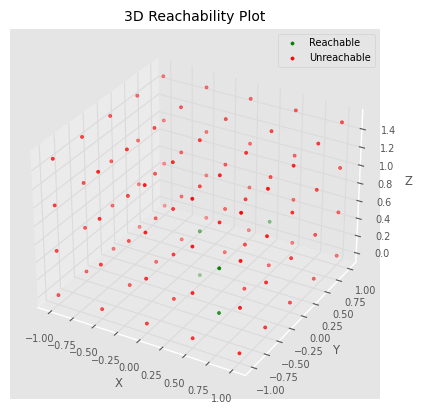

In [45]:
space_dimensions = [2.0, 2.0, 2.0]
reachable_points, unreachable_points, reachable_configs = check_reachable_cubes(long_robot, space_dimensions, 0.5, 0.1)
print("Reachable space %: ", len(reachable_points) / (len(reachable_points) + len(unreachable_points)))
plot_reachability(reachable_points, unreachable_points)

In [46]:
print("Reachable space %: ", len(reachable_points) / (len(reachable_points) + len(unreachable_points)))
print(reachable_points)
for i in range(len(reachable_configs)):
    end_eff = long_robot.fk(reachable_configs[i], collision = True, visual = True)
    print(end_eff)
    target_point = np.array(reachable_points[i])
    actual_point = np.array([end_eff[0][3], end_eff[1][3], end_eff[2][3]])
    print(actual_point)
    distance = np.linalg.norm(target_point - actual_point)
    print("Distance: ", distance)

Reachable space %:  0.05
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.5], [0.5, -0.5, 0.0], [0.5, -0.5, 0.5], [0.5, 0.5, 0.5]]
[[ 0.547 -0.596 -0.587  0.032]
 [-0.834 -0.33  -0.442  0.023]
 [ 0.069  0.732 -0.678  0.018]
 [ 0.     0.     0.     1.   ]]
[0.03187875 0.0231614  0.01769585]
Distance:  0.04319546552424047
[[ 0.716 -0.008 -0.698 -0.026]
 [ 0.535  0.648  0.542  0.029]
 [ 0.448 -0.762  0.468  0.579]
 [ 0.     0.     0.     1.   ]]
[-0.02596584  0.02876697  0.57941752]
Distance:  0.0883680144734631
[[ 0.349 -0.807 -0.477  0.5  ]
 [-0.807 -0.    -0.591 -0.478]
 [ 0.477  0.591 -0.651  0.031]
 [ 0.     0.     0.     1.   ]]
[ 0.50000012 -0.47789278  0.03106664]
Distance:  0.03812958286389376
[[ 0.81   0.287  0.511  0.5  ]
 [ 0.286  0.567 -0.773 -0.544]
 [-0.512  0.772  0.377  0.535]
 [ 0.     0.     0.     1.   ]]
[ 0.5000978  -0.54406478  0.53464428]
Distance:  0.05605301175306768
[[-0.37   0.791  0.487  0.48 ]
 [-0.074 -0.548  0.833  0.56 ]
 [ 0.926  0.272  0.261  0.478]
 [ 0.     0.     0.   